<a href="https://colab.research.google.com/github/milymedina98/InteligenciaArtificial/blob/main/VGG16_Tp3IA_v1_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Visualization
import matplotlib.image as implt # Visualization
import seaborn as sns # Visualization
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime
from sklearn.metrics import confusion_matrix

In [7]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"milagrosmedina","key":"4f5c9bcd8f63c233748e92ea627622b7"}'}

In [8]:
!cp kaggle.json ~/.kaggle/

In [9]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

labeled-chest-xray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
from zipfile import ZipFile
import glob

zip_file = ZipFile('/content/labeled-chest-xray-images.zip')
#opening the zip file in READ mode
with ZipFile('/content/labeled-chest-xray-images.zip', 'r') as zip:
 # extracting all the files
 print('Extracting all the files now...')
 zip.extractall()
 print('Done!')

!cd /content

Extracting all the files now...
Done!


In [11]:
BATCH_SIZE = 64
EPOCHS = 20

TRAIN_PATH = '/content/chest_xray/train'
TEST_PATH = '/content/chest_xray/test'

TRAIN_NORMAL = os.listdir(TRAIN_PATH + '/NORMAL')
TRAIN_PNEUMONIA = os.listdir(TRAIN_PATH + '/PNEUMONIA')

TEST_NORMAL = os.listdir(TEST_PATH + '/NORMAL')
TEST_PNEUMONIA = os.listdir(TEST_PATH + '/PNEUMONIA')


TARGET_SIZE = (300, 300)
GREY = (3,)
INPUT_SIZE = TARGET_SIZE + GREY

CLASSES = ['Normal','Pneumonia']
if (os.path.exists(TRAIN_PATH) and os.path.exists(TEST_PATH)):
    print('OK')
else:
    print('No existen carpetas')

OK


In [12]:
num_train_normal = len(TRAIN_NORMAL)
num_train_pneumonia = len(TRAIN_PNEUMONIA)
num_train = num_train_normal + num_train_pneumonia 

num_test_normal = len(TEST_NORMAL)
num_test_pneumonia = len(TEST_PNEUMONIA)
num_test = num_test_normal + num_test_pneumonia

num_all = num_train + num_test

print('Normal images in train-set: ', num_train_normal) 
print('Pneumonia images in train-set: ', num_train_pneumonia)
print('Total images in train-set: ', num_train,'--->', round(num_train/num_all,3)*100, 'Percent')

print("\nNormal images in test-set:", num_test_normal)
print("Pneumonia images in test-set:", num_test_pneumonia)
print('Total images in test-set: ', num_test, '--->', round(num_test/num_all,3)*100, 'Percent')

print('\nAll the images in Dataset: ', num_all)

Normal images in train-set:  1349
Pneumonia images in train-set:  3883
Total images in train-set:  5232 ---> 89.3 Percent

Normal images in test-set: 234
Pneumonia images in test-set: 390
Total images in test-set:  624 ---> 10.7 Percent

All the images in Dataset:  5856


In [13]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255,
                                   rotation_range=5, # Randomly rotate my image between 0 and 5 degrees.
                                   width_shift_range=0.1, # Horizontal shift.
                                   height_shift_range=0.1, # Vertical shift.
                                   zoom_range=0.1, # Zoom.
                                   horizontal_flip=True, # Randomly flip inputs horizontally.
                                   samplewise_center=True, # Set each sample mean to 0. 
                                   samplewise_std_normalization=True) # Divide each input by its std.
                                   
train_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='training')

validation_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='validation')

image_train, label_train = train_generator.next()


test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(directory=TEST_PATH, batch_size = BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, shuffle=True)

image_test, label_test = test_generator.next()

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
def craete_model():
    
    # Load vgg16 model without the top layer
    model = VGG16(include_top=False, weights='imagenet',input_shape=INPUT_SIZE)

    # Freeze
    model.trainable = False
    
    # New classifier layers
    flatten = Flatten()(model.layers[-1].output) # Flatt last vgg16 layer (except the last).
    fc1 = Dense(units=512, activation='relu')(flatten)
    dropout = Dropout(0.05)(fc1)
    output = Dense(2, activation='softmax')(dropout)
   
    # Define a new Model
    model = Model(inputs=model.input, outputs=output)
    
    # Summary
    model.summary()
    
    return model


model = craete_model()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
______________________________________________________________

In [15]:
opt = optimizers.Nadam(learning_rate=0.00001)
loss = CategoricalCrossentropy()
met = 'accuracy'

# Compile the Model
model.compile(optimizer=opt, loss=loss, metrics=[met])

In [16]:

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%d%m%Y-%H%M%S")

my_callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5, mode='auto',restore_best_weights=False, verbose=1),

                ModelCheckpoint(filepath='my_model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1),

                TensorBoard(log_dir=log_dir, histogram_freq=1) ]

In [17]:
history = model.fit(train_generator, 
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=validation_generator,
                    callbacks=[my_callbacks],
                    steps_per_epoch=3,
                    verbose=1)

print('\n*** Fit is over ***')
model.save('my_model.h5')

Epoch 1/20
3/3 [==============================] - 91s 21s/step - loss: 0.7688 - accuracy: 0.5677 - val_loss: 0.5333 - val_accuracy: 0.7435

Epoch 00001: val_accuracy improved from -inf to 0.74354, saving model to my_model.h5
Epoch 2/20
3/3 [==============================] - 37s 17s/step - loss: 0.5609 - accuracy: 0.7188 - val_loss: 0.4791 - val_accuracy: 0.7550

Epoch 00002: val_accuracy improved from 0.74354 to 0.75502, saving model to my_model.h5
Epoch 3/20
3/3 [==============================] - 41s 17s/step - loss: 0.5327 - accuracy: 0.7355 - val_loss: 0.4165 - val_accuracy: 0.8201

Epoch 00003: val_accuracy improved from 0.75502 to 0.82010, saving model to my_model.h5
Epoch 4/20
3/3 [==============================] - 35s 17s/step - loss: 0.4505 - accuracy: 0.8129 - val_loss: 0.3919 - val_accuracy: 0.8909

Epoch 00004: val_accuracy improved from 0.82010 to 0.89091, saving model to my_model.h5
Epoch 5/20
3/3 [==============================] - 36s 17s/step - loss: 0.3470 - accuracy: 0

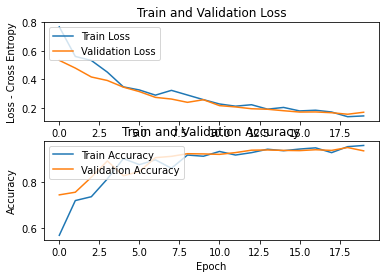

In [18]:
def graphs_learning_display(history):
    
    # Train and Test Loss
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Loss - Cross Entropy')
    plt.title('Train and Validation Loss')
    
    # Train and Test Accuracy
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.xlabel('Epoch'),
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    
    plt.show()
    

graphs_learning_display(history)

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
test_loss = round(test_loss, 6)
test_accuracy = round(test_accuracy*100, 3)

print('Test Loss: ', test_loss)
print('Test Accuracy:', '\033[0m', test_accuracy, '%\033[0m')

Test Loss:  1.612799
Test Accuracy:  62.5 %


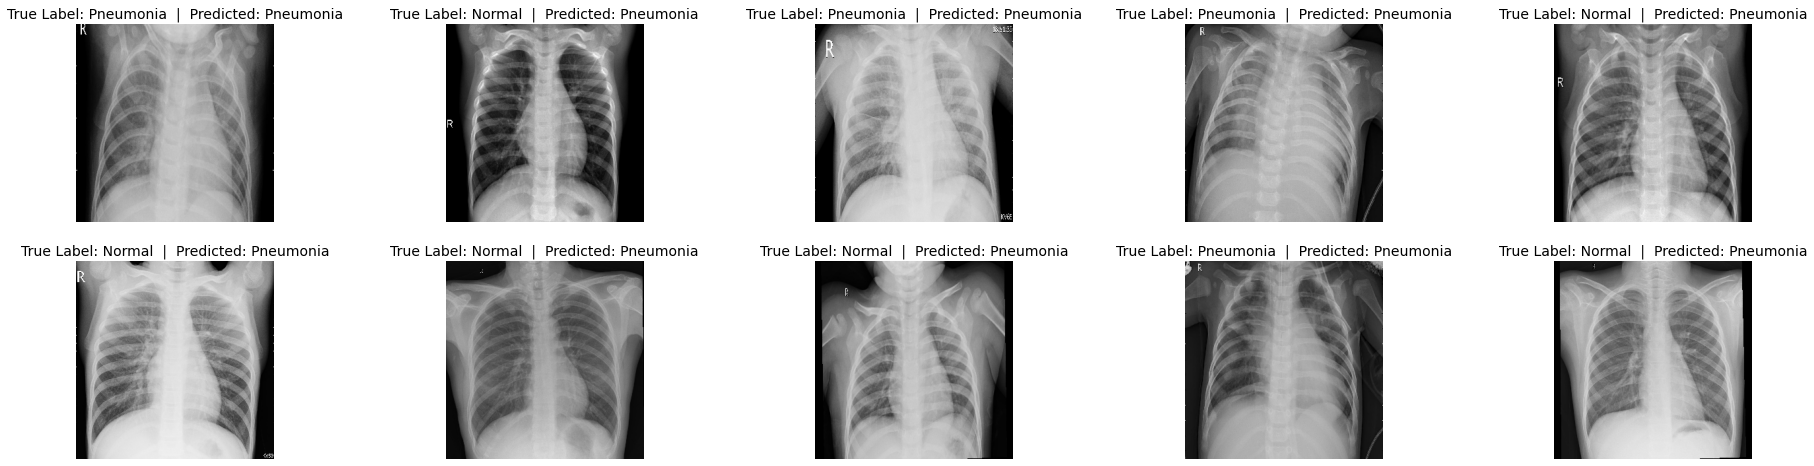

In [20]:
def show(model, batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    predict = np.round(model.predict(images))
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        pred = predict[i]
        axs[i].axis('off')
        lab, pred = np.argmax(lab), np.argmax(pred)
        axs[i].set_title(label = f'True Label: {CLASSES[lab]}  |  Predicted: {CLASSES[pred]}', fontsize=14)

    plt.show()
    
    
show(model, 10, image_test, label_test)

In [21]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras_preprocessing.image import image_data_generator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


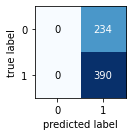

In [22]:
y_pred= model.predict(test_generator).argmax(axis=-1)
y_real=test_generator.classes



matc= confusion_matrix(y_real, y_pred)
names = ['TN','FP','FN','TP']
plot_confusion_matrix(conf_mat=matc, figsize=(2,2), show_normed= False)
plt.tight_layout()
#0=normal 1=neumonia


In [23]:
train_acc = round(np.max(history.history['accuracy'])*100, 2)
valid_acc = round(np.max(history.history['val_accuracy'])*100,2)

print('Training Accuracy:','\033[0m', train_acc, '%\033[0m')
print('Validation Accuracy:','\033[0m', valid_acc, '%\033[0m')
print('Test Accuracy:', '\033[0m', test_accuracy,'%\033[0m')

Training Accuracy:  95.83 %
Validation Accuracy:  94.93 %
Test Accuracy:  62.5 %
